In [1]:
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(2024)

In [4]:
df_train = pd.read_csv("data/train.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


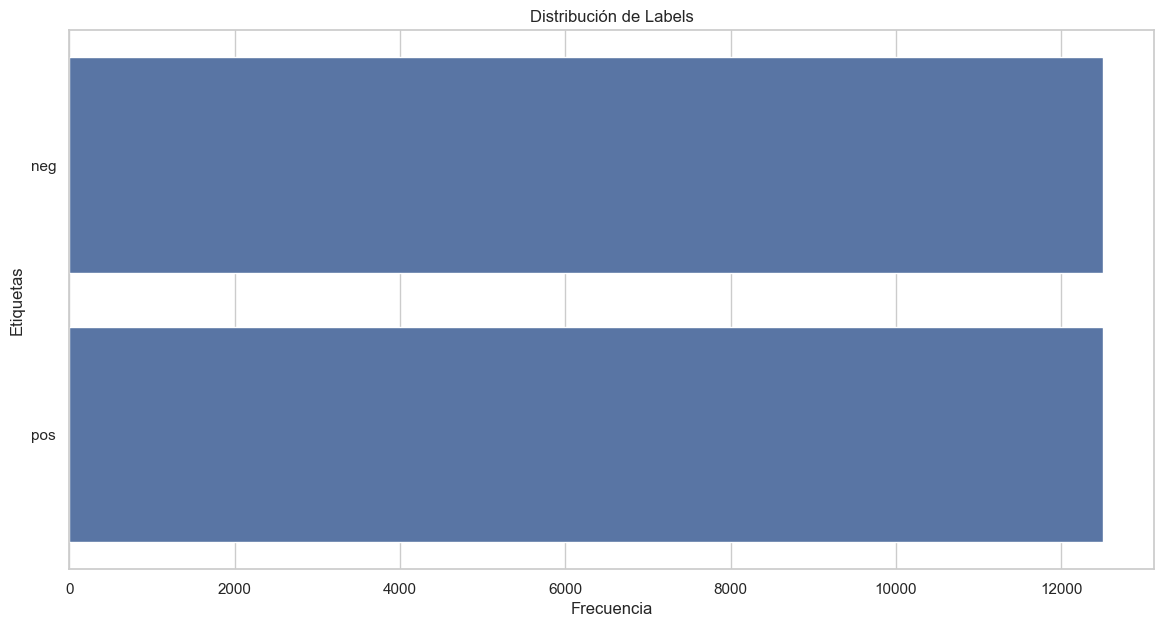

In [5]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

# 2. Prepocesamiento
- Tokenizar
- Eliminar stopwords
- Part-Of-Speech tag
- Lematización

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lista de palabras de negación sintáctica
syntactic_negations = set(["no", "not", "none", "never", "neither", "nor", "cannot", "can't"])

# Lista de prefijos de negación morfológica
morphological_prefixes = ["un", "in", "dis", "im", "ir", "non", "anti"]

def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]

def pos_tagging(tokens):
    return pos_tag(tokens)

# Función para convertir etiquetas de POS de NLTK a etiquetas de WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def mark_negations(tokens):
    # Marca las palabras y frases con negaciones.
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in syntactic_negations:
            negation = True
            negated_tokens.append(token)
        elif negation:
            if token in stop_words:
                negated_tokens.append(token)
            else:
                negated_tokens.append(token + "_NEG")
                negation = False
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def handle_morphological_negations(tokens):
    # Marca las palabras con prefijos de negación morfológica.
    negated_tokens = []
    for token in tokens:
        for prefix in morphological_prefixes:
            if token.startswith(prefix):
                root = token[len(prefix):]
                negated_tokens.append(root + "_NEG")
                break
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def lemmatize(pos_tags):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN) for word, pos in pos_tags]

def preprocess(df):
    df['tokens'] = df['message'].apply(tokenize)
    df['tokens'] = df['tokens'].apply(mark_negations)
    df['tokens'] = df['tokens'].apply(handle_morphological_negations)
    df['pos_tags'] = df['tokens'].apply(pos_tagging)
    df['lemmas'] = df['pos_tags'].apply(lemmatize)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Ejemplo de uso
import pandas as pd

data = {'message': ["The audience disliked the actor leading the play.", 
                    "He was not supposed to come.", 
                    "The price of the car is not insignificant."]}

df = pd.DataFrame(data)
processed_df = preprocess(df)

processed_df[['message', 'tokens', 'lemmas']]

,message,tokens,lemmas
0,The audience disliked the actor leading the play.,"[audience, liked_NEG, actor, leading, play]","[audience, liked_NEG, actor, lead, play]"
1,He was not supposed to come.,"[supposed, come]","[suppose, come]"
2,The price of the car is not insignificant.,"[price, car, significant_NEG]","[price, car, significant_NEG]"


In [8]:
df_train = preprocess(df_train)

In [67]:
# use tf-idf to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)

x = tfidf.fit_transform(df_train['lemmas'].apply(' '.join))

In [94]:
#enconde de y a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['label'])


#verificar que significa cada valor numerico
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2024)

# SVM TEST

In [ ]:
# fast test with training with svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf = SVC()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

## MLP TEST

In [75]:
#MLP
import torch.nn as nn


INPUT_SIZE = 1000
OUTPUT_SIZE = 2

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, 100),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(100, 32),
            nn.ReLU())
        self.fc = nn.Linear(32, OUTPUT_SIZE)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

In [76]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [77]:
# Modelos
model = MLP().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01, weight_decay=0.008)

In [78]:
def train(model, loss_f, optimizer,epochs, x_train, y_train):
  loss_lista = []
  for epoch in range(epochs):

    x_train = x_train.to(device)
    y_train = y_train.to(device)

    # Propagacion adelante
    y_pred = model(x_train)
    loss   = loss_f(y_pred,y_train)
    loss_lista.append(loss.cpu())
    if (epoch%500==0):
      print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss_lista

In [96]:
import pandas as pd
from sklearn.metrics import confusion_matrix

def matriz_confusion(y_test, y_pred, Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index= label_encoder.classes_  , columns=label_encoder.classes_)
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix - "  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()
 
# Write your code here
def test(model, x_test, y_test, tipo):
  if tipo == "MLP":
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(x_test)
    ## Comparar los datos predecidor con los datos de entrenamiento
    # predicted_labels = 0, if (n1 > n2) (no cancer)
    # predicted_labels = 1, if (n1 < n2) (cancer)
    
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    y_test = y_test.cpu()
  else:
    y_pred = model.predict(x_test)
    
  print(classification_report(y_test, y_pred))
  matriz_confusion(y_test, y_pred,"MLP")


In [88]:
import numpy as np
import math
import torch


x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)

print("MLP TRAIN")
loss_list = train(model, loss, optimizer, 5000, x_train_dv, y_train_dv)


MLP TRAIN
Epoch 0: train loss: 6.987620872678235e-05
Epoch 500: train loss: 5.231303657637909e-05
Epoch 1000: train loss: 3.924331394955516e-05
Epoch 1500: train loss: 3.0180377507349476e-05
Epoch 2000: train loss: 2.3081291146809235e-05
Epoch 2500: train loss: 1.7533755453769118e-05
Epoch 3000: train loss: 1.3424472854239866e-05
Epoch 3500: train loss: 1.0177589501836337e-05
Epoch 4000: train loss: 7.750577424303629e-06
Epoch 4500: train loss: 5.935542503721081e-06


              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2463
           1       0.81      0.79      0.80      2537

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



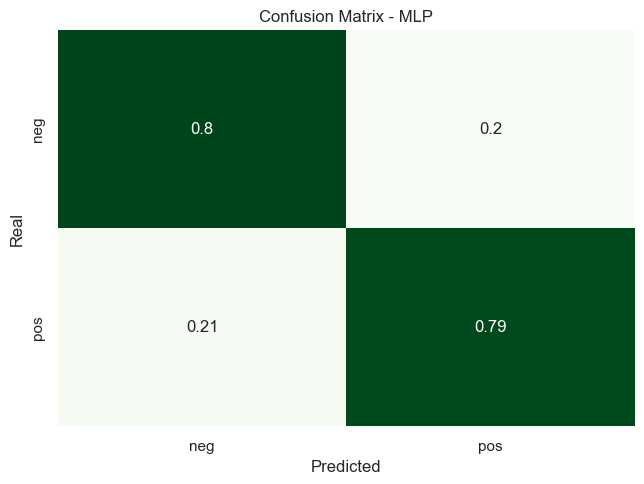

In [97]:
x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test, dtype=torch.long)

test(model, x_test_dv, y_test_dv, "MLP")